# **Tutorial 2: Filtering and Common Transformations**

In this part, we will learn how to implement basic 'cleaning' and spatio-temporal transformations of the data which are common in an analysis pipeline. We will also cover a few "gotcha"s to keep an eye out for. Furthermore, we show some good practices for 'cleaning' the data from unreliable users and/or pings. 

## Introduction

Researchers often filter geospatial datasets to focus on users or trajectories that meet specific criteria—such as sufficient activity, coverage within a particular timeframe, or presence within defined geographic areas. For example, a study might analyze “users with at least 14 days of activity in January who visited Central Park.” Beyond identifying qualifying users, researchers often need to retrieve these users’ complete trajectories across a wider region to study questions like “Where else do Central Park visitors travel from or to around the world?”

Obviously, this reduces the scope of the analysis and makes the sample small and oftentimes manageable without the need for a cluster. However, to get that sample it might be necessary to implement some filtering at read time. 

Building such filters typically involves handling polygon operations, coordinate system transformations, and reconciling inconsistent formats from various data sources.

Below we show a two step process:

1.	Select users that meet specified geographical and temporal conditions.  
2.	Extract the complete trajectories from those users

## Load Data

For this example, we will use a third dataset different than the one used in part 1, which has more users and, occasionally, denser signals. 

In [1]:
import nomad.io.base as loader

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha"}

traj = loader.from_file(filepath_root, format='parquet', traj_cols=tc)
traj.head()

,gc_identifier,dev_x,dev_y,unix_ts,ha,date
0,admiring_brattain,-4.265481e+06,4.393146e+06,1704106881,10.702426,2024-01-01
1,admiring_brattain,-4.265533e+06,4.393159e+06,1704107003,19.015804,2024-01-01
2,admiring_brattain,-4.265477e+06,4.393185e+06,1704107072,24.851835,2024-01-01
3,admiring_brattain,-4.265490e+06,4.393156e+06,1704107268,10.181171,2024-01-01
4,admiring_brattain,-4.265491e+06,4.393147e+06,1704107349,11.100491,2024-01-01


## Ping Frequency

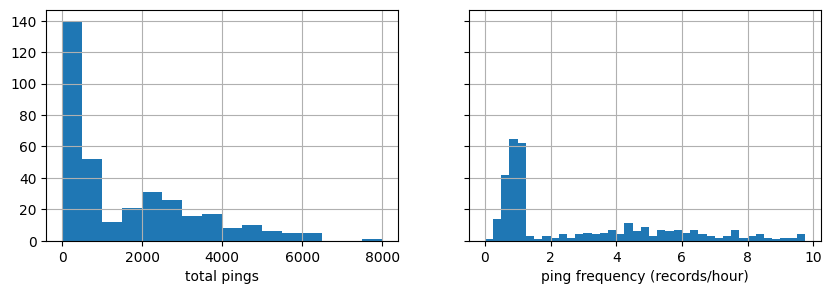

In [16]:
# We can investigate the frequency of these GPS signals, which can be very sparse
import matplotlib.pyplot as plt

total_pings = traj.groupby(tc['user_id']).size()
total_hours = (traj[tc['timestamp']].max() - traj[tc['timestamp']].min())//3600

fig, (ax1, ax2) = plt.subplots(figsize=(10,3), ncols=2, sharey=True)

total_pings.hist(ax=ax1, bins= [500*b for b in range(17)])
ax1.set_xlabel('total pings')

# x-axis restricted to bins
(total_pings/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(40)])
ax2.set_xlabel('ping frequency (records/hour)')

plt.show()

We note **heterogeneity in the ping frequencies** and the volume of data. However, a common gotcha in this type of analysis is to assume that *more records* = *more complete signals*. Due to how the data is collected---often in short bursts---there are users with fewer pings but **more evenly distributed** over the study period. Furthermore, many pings might have such high levels of error, that they shouldn't even be considered in the analysis. Some minimal cleaning already changes the picture. 

In [20]:
from nomad import filters

# Remove horizontal accuracy over 50m
traj_ds = traj.loc[traj[tc['ha']] < 50]
print(f"{((traj[tc['ha']]>50).mean()*100).round(3)}% pings have 'ha' > 50m")
# Downsampling pings to once per minute
time_res_mins=1 # Try 5
traj_ds = filters.downsample(traj_ds, minutes=time_res_mins, traj_cols=tc)

print(f"{100 - 100* len(traj_ds)/len(traj):.3f}% of records had (per user) {time_res_mins}-minute duplicates (or ha>50)")

1.705% pings have 'ha' > 50m
13.436% of records had (per user) 1-minute duplicates (or ha>50)


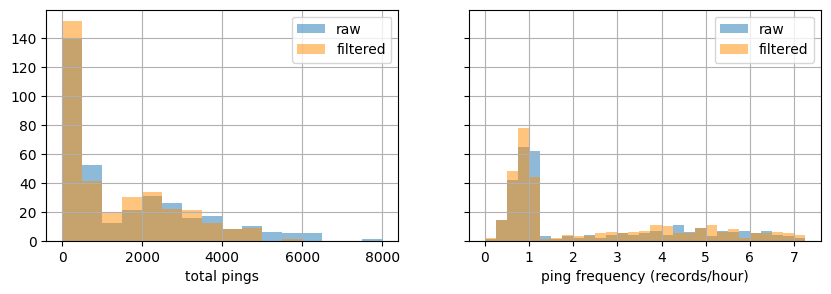

In [27]:
total_pings_filtered = traj_ds.groupby(tc['user_id']).size()

fig, (ax1, ax2) = plt.subplots(figsize=(10,3), ncols=2, sharey=True)

total_pings.hist(ax=ax1, bins= [500*b for b in range(17)], alpha=0.5, label='raw')
total_pings_filtered.hist(ax=ax1, bins= [500*b for b in range(17)], color='darkorange', alpha=0.5, label='filtered')
ax1.legend()
ax1.set_xlabel('total pings')

(total_pings/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(30)], alpha=0.5, label='raw')
(total_pings_filtered/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(30)], color='darkorange', alpha=0.5, label='filtered')
ax2.set_xlabel('ping frequency (records/hour)')
ax2.legend()

plt.show()

`nomad`'s `filters.downsample` method automatically takes care of grouping by user if the name of a user id column is passed (in this case via `traj_cols`), but it would also work for a single trajectory or on a `pandas.datetime64` datetime column if available.

In [1]:
import pandas as pd
import numpy as np

from shapely.geometry import Polygon
from datetime import datetime
import matplotlib.patches as patches

from nomad.filters import to_projection, filter_users, q_filter

## Spatial filters 

Suppose we are interested in an analysis of users who visited a park during multiple days of January 2024. In particular, we might want to know which other locations these users tend to visit to try and get some insights. Naturally, we do this through a spatial join of each user's coordinates with the polygon that represents the park. Here are some possible immediate challenges that could make an analysis `ad-hoc`

- The polygon could be in **spherical coordinates** (also called **geographic coordinates**) and the data in **projected coordinates**. For example, in `(longitude, latitude)` coordinates with `crs=EPSG4360`, while the data has ``` (x, y)``` coordinates from the Web Mercator crs (`EPSG:3857`).

- The polygon could be represented as a Well-Known-Text string (`wkt`), `shapely` polygon (or multipolygon), or a `Geopandas.GeoSeries`

We can get a `shapely.Polygon` representing the park querying from the file `garden_city.geojson` but, for the sake of completeness, we will assume that the polygon is given by a `wkt`

In [71]:
import geopandas as gpd
import pyproj # for coordinate reprojection
from shapely.geometry import Polygon, box
import shapely.plotting as shp_plt

city = gpd.read_file("garden_city.geojson").set_index('building_id')
poly = city.geometry.loc['p-x13-y11']

poly_wkt = 'POLYGON ((-38.31767437672955 36.66929877196072, -38.31767437672955 36.66973109167419,'\
                     '-38.31821336590002 36.66973109167419, -38.31821336590002 36.66929877196072,'\
                     '-38.31767437672955 36.66929877196072))'

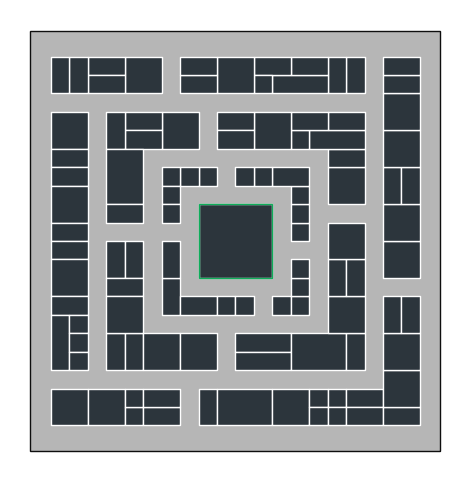

In [96]:
# for pretty plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_axis_off()

outer_box = box(*city.total_bounds).buffer(0.00015, join_style='mitre')
shp_plt.plot_polygon(outer_box, ax=ax, add_points=False, color='#0e0e0e')
city.plot(ax=ax, edgecolor='white', color='#2c353c')
shp_plt.plot_polygon(poly, ax=ax, add_points=False, edgecolor='#0fad5a', facecolor='none')

plt.show()

In [79]:
outer_box.exterior.coords.xy

(array('d', [-38.316596398388604, -38.319291344240966, -38.319291344240966, -38.316596398388604, -38.316596398388604]),
 array('d', [36.6684341252476, 36.6684341252476, 36.67059572381487, 36.67059572381487, 36.6684341252476]))

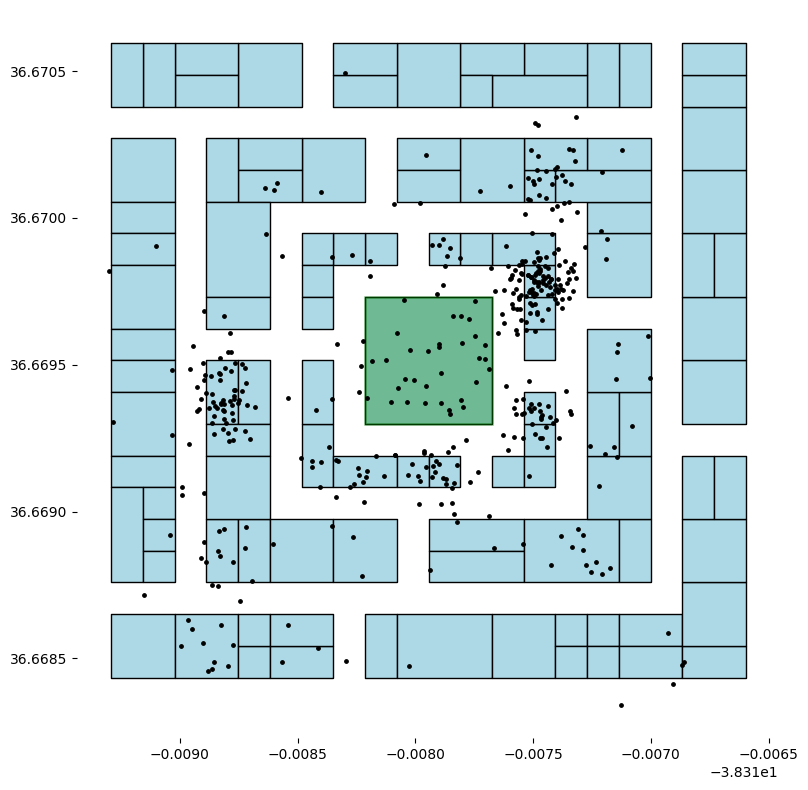

In [ ]:


fig, ax = plt.subplots(figsize=(8, 8))
plt.box(on=False)

# Load the GeoJSON file of the city map and plot
gdf = gpd.read_file('garden_city.geojson')
gdf.plot(ax=ax, color='lightblue', edgecolor='black', zorder=1)

# Plot the trajectory pings
plot_df = traj[traj['uid'] == "fervent_knuth"].copy()
ax.scatter(x=plot_df['longitude'], 
           y=plot_df['latitude'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Define the polygon coordinates for the park area
polygon_coords = [
    (-38.317674376729549, 36.669298771960719), 
    (-38.317674376729549, 36.669731091674187), 
    (-38.318213365900021, 36.669731091674187), 
    (-38.318213365900021, 36.669298771960719)
]
polygon = Polygon(polygon_coords)
polygon_patch = patches.Polygon(polygon.exterior.coords, 
                                closed=True, 
                                edgecolor='green', 
                                facecolor='green', 
                                alpha=0.35, 
                                linewidth=2, 
                                label="Polygon")
plt.gca().add_patch(polygon_patch)

plt.tight_layout()
plt.show()

## Coordinate system projection

The first step after loading the dataset is to ensure the dataset is in the expected coordinate system.

Many geospatial datasets come in spherical coordiantes latitude/longitude (EPSG:4326). However, spatial analyses---like joins of points in polygons, computing buffers, or clustering pings---might benefit from computing euclidean distances. Thus projected planar coordinates (like EPSG:3857) are commonly used. Nomad's `to_projection` method creates new columns `x` and `y` with projected coordinates in any coordinate reference system (CRS) recognized by PyProj. 

In [4]:
# Project to EPSG:3857 (Web Mercator)
projected_x, projected_y = to_projection(traj=traj,
                                         input_crs="EPSG:4326",
                                         output_crs="EPSG:3857",
                                         longitude="longitude",
                                         latitude="latitude")

traj['x'] = projected_x
traj['y'] = projected_y

traj.head(10)

,uid,timestamp,longitude,latitude,datetime,ha,date,tz_offset,x,y
0,fervent_knuth,1704107522,-38.317331,36.669819,2024-01-01 07:12:02,20.079080,2024-01-01,-14400,-4.265466e+06,4.393183e+06
1,fervent_knuth,1704108613,-38.317394,36.669747,2024-01-01 07:30:13,19.085910,2024-01-01,-14400,-4.265473e+06,4.393173e+06
2,fervent_knuth,1704109838,-38.317479,36.669865,2024-01-01 07:50:38,13.173027,2024-01-01,-14400,-4.265482e+06,4.393190e+06
3,fervent_knuth,1704110272,-38.317346,36.669794,2024-01-01 07:57:52,9.367617,2024-01-01,-14400,-4.265467e+06,4.393180e+06
4,fervent_knuth,1704110645,-38.317207,36.670156,2024-01-01 08:04:05,10.999287,2024-01-01,-14400,-4.265452e+06,4.393230e+06
5,fervent_knuth,1704149735,-38.317458,36.669780,2024-01-01 18:55:35,10.286091,2024-01-01,-14400,-4.265480e+06,4.393178e+06
6,fervent_knuth,1704154040,-38.317577,36.669823,2024-01-01 20:07:20,8.146017,2024-01-01,-14400,-4.265493e+06,4.393184e+06
7,fervent_knuth,1704155088,-38.317494,36.669850,2024-01-01 20:24:48,11.449836,2024-01-01,-14400,-4.265484e+06,4.393187e+06
8,fervent_knuth,1704164362,-38.317490,36.669617,2024-01-01 22:59:22,14.431841,2024-01-01,-14400,-4.265484e+06,4.393155e+06
9,frosty_neumann,1704118728,-38.317645,36.669408,2024-01-01 10:18:48,41.010484,2024-01-01,-14400,-4.265501e+06,4.393126e+06


## Apply desired filters

Our library currently allows for three common forms of filtering:
- **Temporal Filtering**: Restrict data to a time window of interest (e.g., January). Use the `start_time` and `end_time` arguments. If 
- **Quantity-Based Filtering**: Keep only users with sufficient activity as measured by a minimum number of pings. Use the `min_active_days` and `min_pings_per_day` arguments.
- **Spatial Filtering**: Keep only users with pings that fall within a specific geographic region (e.g., Philadelphia). Use the `polygon` argument.

If the aforementioned arguments are not specified, the default arguments ensure that the respective filtering is not performed. I.e., `polygon` defaults to `None`, and so no spatial filtering is performed.

In [5]:
# Define the polygon for the park area (in projected coordinates)
polygon_coords = [
    (-4265504, 4393111), 
    (-4265504, 4393171), 
    (-4265564, 4393171), 
    (-4265564, 4393111)
]
polygon = Polygon(polygon_coords)

n0 = len(traj)
uq0 = traj['uid'].unique()

filtered_traj = filter_users(traj=traj, 
                             start_time=pd.Timestamp("2024-01-01 00:00:00", tz='America/New_York'),
                             end_time=pd.Timestamp("2024-01-07 23:59:00", tz='America/New_York'),
                             polygon=polygon,
                             min_active_days=2,
                             min_pings_per_day=10,
                             user_id='uid',
                             x='x',
                             y='y')

n1 = len(filtered_traj)
uq1 = filtered_traj['uid'].unique()
print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")


Number of pings before filtering: 404448
Number of unique users before filtering: 200
Number of pings after filtering: 32874
Number of unique users after filtering: 36


### Visualize completeness and filter by completeness metric

And here, a discussion on how we want to discard users that have too incomplete a signal to be used. E.g. Q < 80% . 

In [ ]:
#  _generate_Q_matrix(df, traj_cols={'datetime':'event_zoned_datetime', 'user_id':'cuebiq_id'})
# num_days = 42

# q_hourly = Q.mean(axis=0)*100
# q_daily = ((Q>0.0).sum(axis=0)/num_days)*100

# # assume Q is your DataFrame and q_daily is the Series of mean completeness per user
# sorted_cols = q_daily.sort_values(ascending=False).index
# Qs = Q[sorted_cols]
# binary = Qs.gt(0).astype(int)
# cmap = plt.cm.Blues

# fig, axes = plt.subplots(
#     2, 2,
#     figsize=(8, 8),
#     gridspec_kw={'height_ratios': [1, 2.5]},
#     sharey='row'
# )

# # marginal histograms
# axes[0,0].hist(q_daily, bins=46)
# axes[0,0].set_xlabel('% days with data')

# axes[0,1].hist(q_hourly, bins=46)
# axes[0,1].set_xlabel('% hours with data')

# for ax, data in zip([axes[0,1], axes[0,0]], (q_hourly, q_daily)):
#     ax.axvline(np.median(data), linestyle='--', color='red', lw=1)
# # binary heatmap
# sns.heatmap(
#     binary.T,
#     ax=axes[1,0],
#     cmap=cmap,
#     vmin=0, vmax=1,
#     cbar=False,
#     xticklabels=False,
#     yticklabels=False
# )
# axes[1,0].set_ylabel('User')

# # continuous heatmap
# sns.heatmap(
#     Qs.T,
#     ax=axes[1, 1],
#     cmap=cmap,
#     vmin=0, vmax=1,
#     cbar_kws={'label': 'Completeness'},
#     xticklabels=False,
#     yticklabels=False
# )
# axes[1,1].set_ylabel('')

# # set date ticks on bottom row
# dates = pd.to_datetime(Qs.index)
# tick_locs = np.linspace(0, len(dates) - 1, 6, dtype=int)
# tick_lbls = dates.strftime('%m-%d')[tick_locs]
# for ax in [axes[1,0], axes[1,1]]:
#     ax.set_xticks(tick_locs)
#     ax.set_xticklabels(tick_lbls, rotation=45, ha='right')

# #plt.tight_layout()
# plt.show()

The following code constructs a daily $Q$ matrix, which represents the completeness of user activity for each day. $q$ represents the proportion of hours in a day during which a specific user has recorded activity. A sliding window of 3 days is then applied to compute a mean completeness metric for each date in the sliding window.

In [ ]:
# Construct daily Q matrix
Q = filters._generate_Q_matrix(traj, tc)
Q

# no need for sliding window
# visualize (1) distribution of q=0, (2) barcode 0/1 for each hour for each user plt.imshow

In [ ]:
sliding_window = 3  # in days
SW_dates = Q.index[:-sliding_window]  # dates involved in the sliding window computation
Q_window = pd.DataFrame(
    [filters._compute_mean_q(Q, date, sliding_window) for date in SW_dates],
    index=SW_dates
    )

Q_window.head(5)

We now visualize the number of complete users in each day for different values of completeness ($\bar{q} = 1-\epsilon$).

In [ ]:
LIST_eps = [0.3,0.5]
Colors_eps = ['red', 'blue']
X = range(len(SW_dates))

DICT_legend= {'classes': [int(e*100) for e in LIST_eps], 
              'colors': Colors_eps, 
              'loc': 'lower right', 
              'fontsize':10,
              'title': '$\\epsilon \\quad (\\%)$', 
              'title_fontsize':10}

DICT_ticks = {'t': X, 
              'tl': SW_dates, 
              'rot': 90, 
              'size':10}

DICT_label_titles = {'xlabel': 'Date', 
                     'ylabel': 'Count of complete users', 
                     'title': f'Daily time-series of complete users \n over {sliding_window} days sliding window with $\\epsilon$ tolerance', 
                     'label_size': 15, 
                     'title_size': 15}

fig, ax = plt.subplots(figsize = (15,5))

for eps,color in zip(LIST_eps, Colors_eps):
    #Counts of complete users for each date - based on eps tolerance
    I_complete_eps = (Q_window > (1-eps)).sum(axis=1)
    ax.plot(X, I_complete_eps.values, color = color, label = eps)

filters._ax_visual_legend(ax, DICT_legend)
filters._ax_visual_ticklabel(ax, DICT_ticks, axis = 'x')
filters._ax_visual_labeltitles(ax, DICT_label_titles)

We can use $q$ to filter users by completeness, retaining only the users who exhibit a mean completeness of over `qbar` in the sample.

In [ ]:
n0 = len(traj)
uq0 = traj['uid'].unique()

complete_users = q_filter(traj=traj,
                          qbar=0.7,
                          sliding_window=3,
                          traj_cols=tc)
filtered_traj_q = traj[traj['uid'].isin(complete_users)]

n1 = len(filtered_traj_q)
uq1 = filtered_traj_q['uid'].unique()

print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")

## Applying filters on read

If your dataset is too large. Loading it all in memory to then apply the filters can be intractable. Nomad implements these functionalities to filter in this way on read...